First, load the data,in this notebook we are using the PMI data from the paper:"Environmental predictors impact microbialbased postmortem interval (PMI) estimation models within human decomposition soils". The preprocessed data includes OTU/phylum/class/order abundance matrices (includes or not include environmental factors)

In [1]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import RunML_continue
import FS
import metric



2025-01-17 02:24:07.096555: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-17 02:24:07.100128: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-17 02:24:07.298853: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-17 02:24:07.354141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737098647.461691 1635715 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737098647.46

In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import pickle
import matplotlib.pyplot as plt
import glob
import os

In [3]:
PMIdata_path = '../data/count_table/'

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras as ks
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow.keras.models import Model


## No env model
16s (OTU/phylum/class/order) - no env

ITS (OTU/phylum/class/order) - no env

16s+ITS (OTU/phylum/class/order) - no env (only use this data when calculating H)
bact.ITS.n.class.env

### Data preprocess


In [5]:
bact_ITS_noenv_files = glob.glob(PMIdata_path + 'bact.ITS.n.*.noenv.csv')


In [6]:
bact_ITS_noenv_files

['../data/count_table/bact.ITS.n.otu.noenv.csv',
 '../data/count_table/bact.ITS.n.class.noenv.csv',
 '../data/count_table/bact.ITS.n.order.noenv.csv',
 '../data/count_table/bact.ITS.n.phylum.noenv.csv']

In [7]:
# Read each CSV file into a list of dataframes
bact_ITS_noenv_df_list = [pd.read_csv(file) for file in bact_ITS_noenv_files]
taxlabels = ['OTU', 'class', 'order', 'phylum']

In [8]:
for df in bact_ITS_noenv_df_list:
    print(df.shape)
    


(78, 7415)
(78, 178)
(78, 412)
(78, 52)


In [9]:
# target variable
y = bact_ITS_noenv_df_list[3].iloc[:, 0].values 

# Define the threshold
y_threshold = 2500

# Categorize the series based on the threshold
y = np.where(y > y_threshold, 'LONG', 'SHORT')

print(y)

print(list(y).count('LONG'))
print(list(y).count('SHORT'))

['SHORT' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'SHORT' 'SHORT'
 'SHORT' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG'
 'LONG' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT'
 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT'
 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG'
 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT'
 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT'
 'LONG' 'LONG' 'SHORT' 'SHORT' 'SHORT' 'SHORT' 'SHORT' 'SHORT' 'LONG'
 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG']
35
43


In [10]:
df_list = []
col_names_4taxa=[]
for df in bact_ITS_noenv_df_list:
    data = df.drop(df.columns[0], axis=1)# delete the response column
    df_list.append(data)
    cols_name = df.columns
    col_names_4taxa.append(cols_name)

#### OTU

##### 1. calculate H statistics for OTU/phylum/class/order (both 16s and ITS)

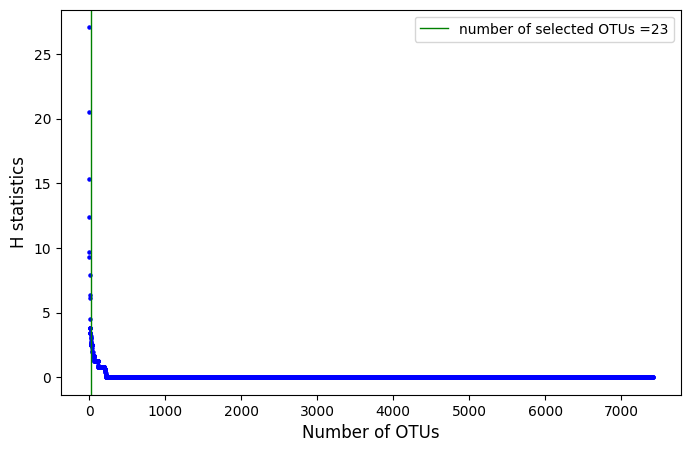

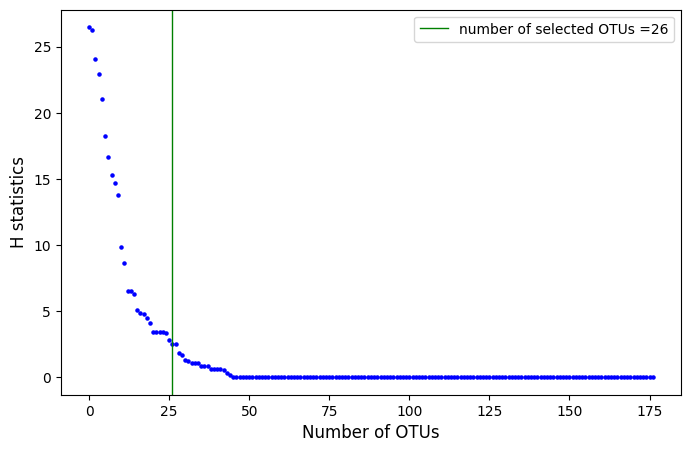

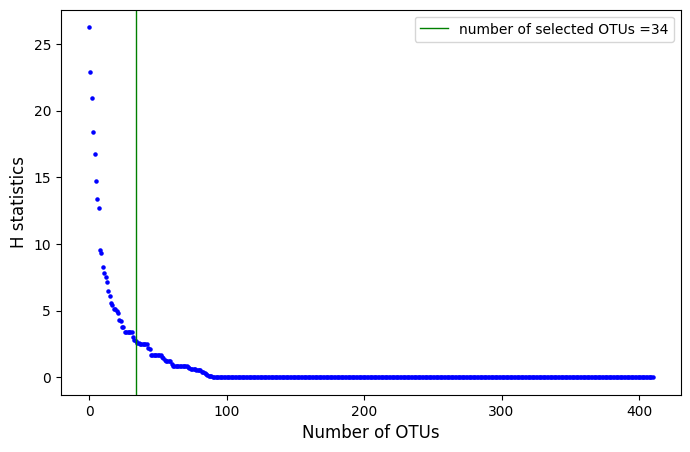

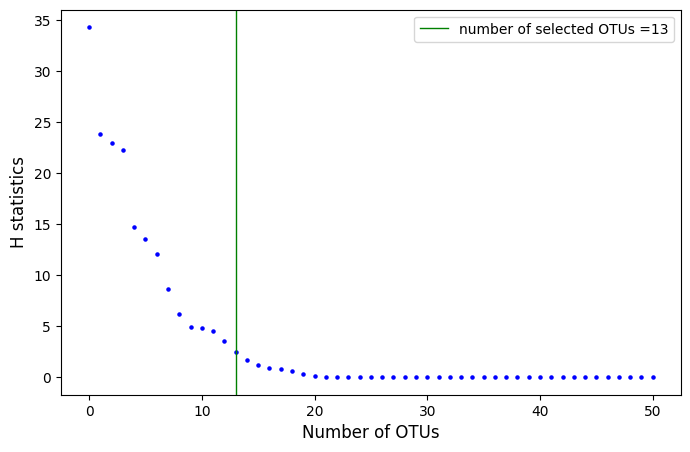

In [11]:
data_4taxa = []
weights_4taxa = []
selectedOTU_index_4tax = []
X_FS_4taxa = []
selectedASVs_4taxa = []
eps_4tax = []
for df in df_list:
    select_result = FS.SelectMicro_fun(df,y)
    data_4taxa.append(select_result['relative_abundance_data'])
    weights_4taxa.append(select_result['H_score'])
    selectedOTU_index_4tax.append(select_result['selected_indices'])
    X_FS_4taxa.append(select_result['selected_data'])
    selectedASVs_4taxa.append(select_result['selected_columnames'])
    eps = len(select_result['selected_indices'])
    eps_4tax.append(eps)

In [12]:
param_grid = {
            #'input_dim': [X_train_scaled.shape[1]], 
            'latent_dim': [10, 25, 50, 100],
            'activation': ['relu', 'sigmoid', 'tanh']  
        }


#### 4. Model
Prepare 4 datasets: full dataset, our selected dataset, Lasso selected  dataset(based on the target variable), randomly selected data (selected the same numer of variables as in our method)

Use random forest and SVM as classifier, and will build both models for each response variable.

For Lasso, the dataset will be determined by the response variable, so the lasso subset is different for the models for different response variables.

For random selection, the  process will repeat iter=30 times to  find the mean accuracy and AUC

SMOTE  is used (the data is not balanced, as we can see the performance is really bad especially for SVM model when not using SMOTE)

In [13]:
iter =30
cls = ["RF","SVM", "CatBoost","NB"]

In [14]:
targetLabel=y
data_AE_4taxa = []

In [15]:
# AE
data_train, data_test, y_train, y_test = RunML_continue.split_and_scale_data(data_4taxa[0],targetLabel)
shape = data_train.shape[1:]
best_score = float('inf')
best_model = None
for activation1 in param_grid['activation']:

    class Autoencoder(Model):
      def __init__(self, latent_dim, shape):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.shape = shape
        self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(latent_dim, activation=activation1),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(tf.math.reduce_prod(shape).numpy(), activation=activation1),
          layers.Reshape(shape)
        ])
    
      def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    for latent_dim in param_grid['latent_dim']:
        autoencoder = Autoencoder(latent_dim, shape)
        autoencoder.compile(optimizer='adam', loss=ks.losses.MeanSquaredError())
        autoencoder.fit(data_train, data_train,
                    epochs=10,
                    shuffle=True,
                    verbose=0,
                    validation_data=(data_test, data_test))
        val_loss = autoencoder.evaluate(data_test, data_test, verbose=0)
        if val_loss < best_score:
            best_score = val_loss
            print(f"activation 1:{activation1},latent_dim:{latent_dim}, val_loss:{val_loss}")
            best_model = autoencoder
        
data_AE = best_model.encoder(data_4taxa[0]).numpy() 

data_subset = {"Allfeature":data_4taxa[0],
            "AE":data_AE}

data_AE_4taxa.append(data_subset)

2025-01-17 02:24:13.826155: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


activation 1:relu,latent_dim:10, val_loss:0.025657152757048607
activation 1:relu,latent_dim:25, val_loss:0.02563577890396118
activation 1:relu,latent_dim:100, val_loss:0.025484835729002953


In [16]:
data_train, data_test, y_train, y_test = RunML_continue.split_and_scale_data(data_4taxa[1],targetLabel)
shape = data_train.shape[1:]
best_score = float('inf')
best_model = None
for activation1 in param_grid['activation']:
    class Autoencoder(Model):
      def __init__(self, latent_dim, shape):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.shape = shape
        self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(latent_dim, activation=activation1),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(tf.math.reduce_prod(shape).numpy(), activation=activation1),
          layers.Reshape(shape)
        ])
    
      def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    for latent_dim in param_grid['latent_dim']:
        autoencoder = Autoencoder(latent_dim, shape)
        autoencoder.compile(optimizer='adam', loss=ks.losses.MeanSquaredError())
        autoencoder.fit(data_train, data_train,
                    epochs=10,
                    shuffle=True,
                    verbose=0,
                    validation_data=(data_test, data_test))
        val_loss = autoencoder.evaluate(data_test, data_test, verbose=0)
        if val_loss < best_score:
            best_score = val_loss
            print(f"activation 1:{activation1},latent_dim:{latent_dim}, val_loss:{val_loss}")
            best_model = autoencoder
        
data_AE = best_model.encoder(data_4taxa[1]).numpy() 

data_subset = {"Allfeature":data_4taxa[1],
            "AE":data_AE}

data_AE_4taxa.append(data_subset)

activation 1:relu,latent_dim:10, val_loss:0.3235827088356018
activation 1:tanh,latent_dim:100, val_loss:0.31719645857810974


In [17]:
data_train, data_test, y_train, y_test = RunML_continue.split_and_scale_data(data_4taxa[2],targetLabel)
shape = data_train.shape[1:]
best_score = float('inf')
best_model = None
for activation1 in param_grid['activation']:
    
    class Autoencoder(Model):
      def __init__(self, latent_dim, shape):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.shape = shape
        self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(latent_dim, activation=activation1),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(tf.math.reduce_prod(shape).numpy(), activation=activation1),
          layers.Reshape(shape)
        ])
    
      def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    for latent_dim in param_grid['latent_dim']:
        autoencoder = Autoencoder(latent_dim, shape)
        autoencoder.compile(optimizer='adam', loss=ks.losses.MeanSquaredError())
        autoencoder.fit(data_train, data_train,
                    epochs=10,
                    shuffle=True,
                    verbose=0,
                    validation_data=(data_test, data_test))
        val_loss = autoencoder.evaluate(data_test, data_test, verbose=0)
        if val_loss < best_score:
            best_score = val_loss
            print(f"activation 1:{activation1}, latent_dim:{latent_dim}, val_loss:{val_loss}")
            best_model = autoencoder
        
data_AE = best_model.encoder(data_4taxa[2]).numpy() 

data_subset = {"Allfeature":data_4taxa[2],
            "AE":data_AE}

data_AE_4taxa.append(data_subset)

activation 1:relu, latent_dim:10, val_loss:0.2336241751909256
activation 1:relu, latent_dim:50, val_loss:0.23152542114257812
activation 1:relu, latent_dim:100, val_loss:0.2277207225561142


In [18]:
data_train, data_test, y_train, y_test = RunML_continue.split_and_scale_data(data_4taxa[3],targetLabel)
shape = data_train.shape[1:]
best_score = float('inf')
best_model = None
for activation1 in param_grid['activation']:
    class Autoencoder(Model):
      def __init__(self, latent_dim, shape):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.shape = shape
        self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(latent_dim, activation=activation1),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(tf.math.reduce_prod(shape).numpy(), activation=activation1),
          layers.Reshape(shape)
        ])
    
      def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    for latent_dim in param_grid['latent_dim']:
        autoencoder = Autoencoder(latent_dim, shape)
        autoencoder.compile(optimizer='adam', loss=ks.losses.MeanSquaredError())
        autoencoder.fit(data_train, data_train,
                    epochs=10,
                    shuffle=True,
                    verbose=0,
                    validation_data=(data_test, data_test))
        val_loss = autoencoder.evaluate(data_test, data_test, verbose=0)
        if val_loss < best_score:
            best_score = val_loss
            print(f"activation 1:{activation1},latent_dim:{latent_dim}, val_loss:{val_loss}")
            best_model = autoencoder
        
data_AE = best_model.encoder(data_4taxa[3]).numpy() 

data_subset = {"Allfeature":data_4taxa[3],
            "AE":data_AE}

data_AE_4taxa.append(data_subset)

activation 1:relu,latent_dim:10, val_loss:0.36892008781433105
activation 1:relu,latent_dim:100, val_loss:0.30256175994873047
activation 1:tanh,latent_dim:100, val_loss:0.2762966454029083


In [19]:
len(data_AE_4taxa)

4

In [20]:
with open('../data/data_AE_4taxa.pkl', 'wb') as file:
    pickle.dump(data_AE_4taxa, file)

Index(['ITS00002', 'ITS00001', 'ITS00006', 'Otu00009', 'ITS00008', 'Otu00008',
       'Otu00007', 'ITS00013', 'ITS00014', 'ITS00012', 'Otu00003', 'Otu00014',
       'Otu00039', 'ITS00011', 'ITS00043'],
      dtype='object')
(78, 15)
Validation passed: Dimensions are correct.
Long= 35, short = 43
         OTU  presence_pos  presence_neg
0   ITS00002      0.828571      0.279070
1   ITS00001      0.800000      0.279070
2   ITS00006      0.228571      0.627907
3   Otu00009      0.028571      0.348837
4   ITS00008      0.400000      0.116279
5   Otu00008      0.200000      0.000000
6   Otu00007      0.057143      0.302326
7   ITS00013      0.200000      0.023256
8   ITS00014      0.200000      0.023256
9   ITS00012      0.114286      0.302326
10  Otu00003      0.085714      0.000000
11  Otu00014      0.085714      0.000000
12  Otu00039      0.085714      0.000000
13  ITS00011      0.085714      0.000000
14  ITS00043      0.085714      0.000000


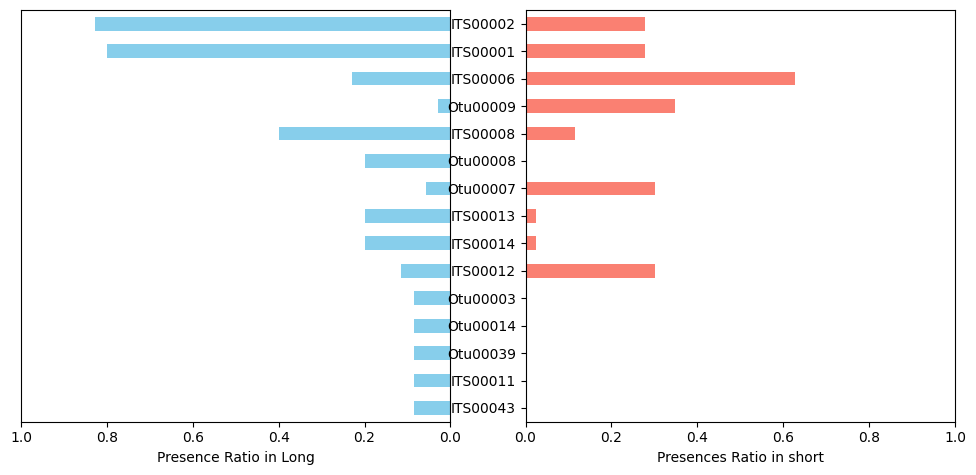

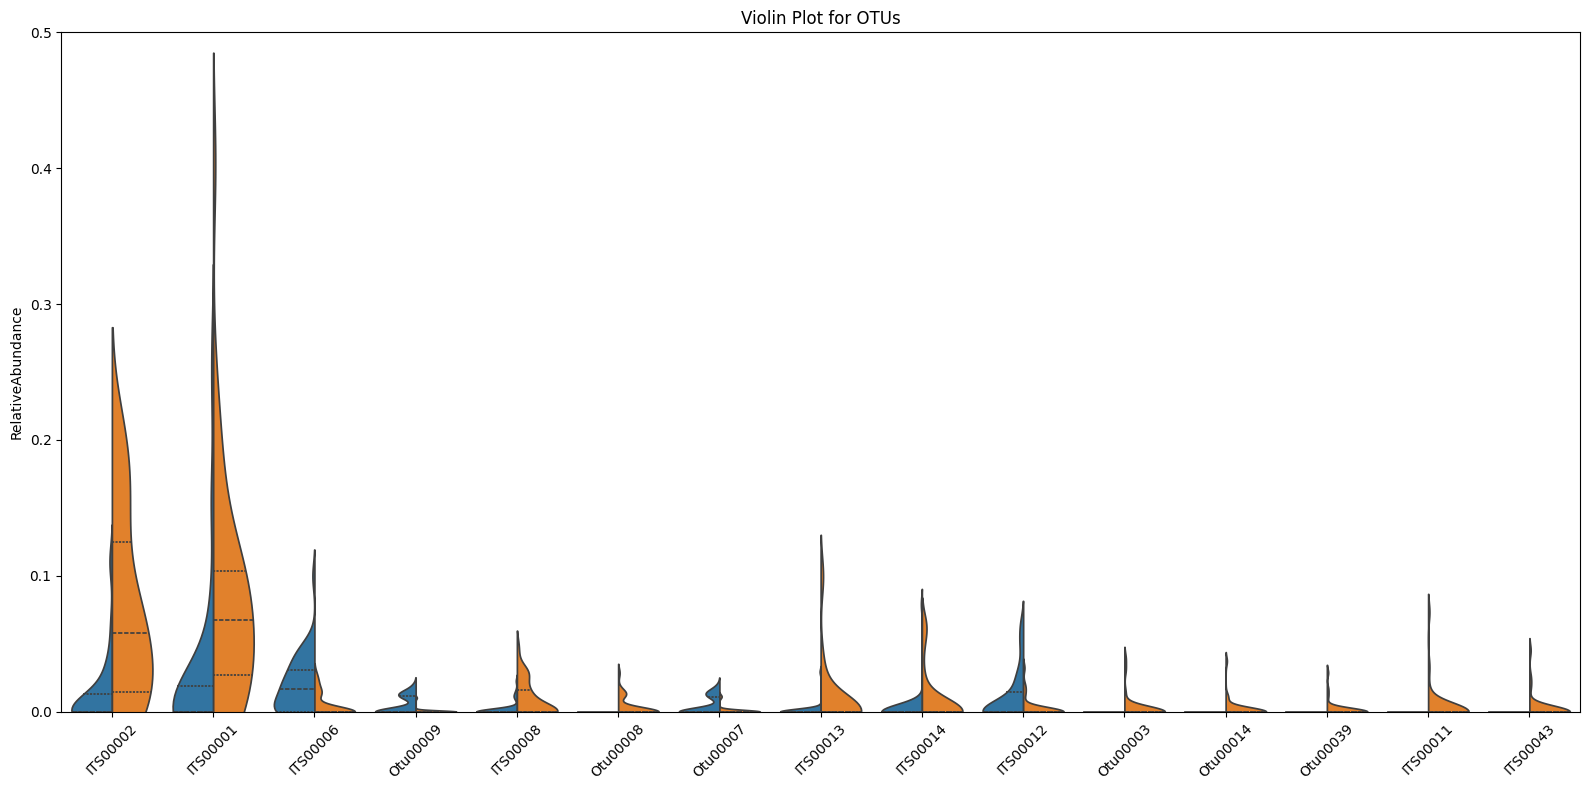

Index(['c__Dothideomycetes', 'c__Saccharomycetes', 'c__Agaricomycetes',
       'k__Fungi_unclassified', 'Clostridia', 'Bacilli', 'Subgroup_6',
       'Deltaproteobacteria', 'c__unclassified_Fungi',
       'Blastocatellia_(Subgroup_4)', 'c__Rozellomycotina_cls_Incertae_sedis',
       'Verrucomicrobiae', 'Phycisphaerae', 'c__unclassified_Rozellomycota',
       'Actinobacteria'],
      dtype='object')
(78, 15)
Validation passed: Dimensions are correct.
Long= 35, short = 43
                                      OTU  presence_pos  presence_neg
0                      c__Dothideomycetes      0.142857      0.720930
1                      c__Saccharomycetes      0.885714      0.488372
2                       c__Agaricomycetes      0.257143      0.790698
3                   k__Fungi_unclassified      0.685714      0.953488
4                              Clostridia      0.600000      0.139535
5                                 Bacilli      0.685714      0.279070
6                              Subg

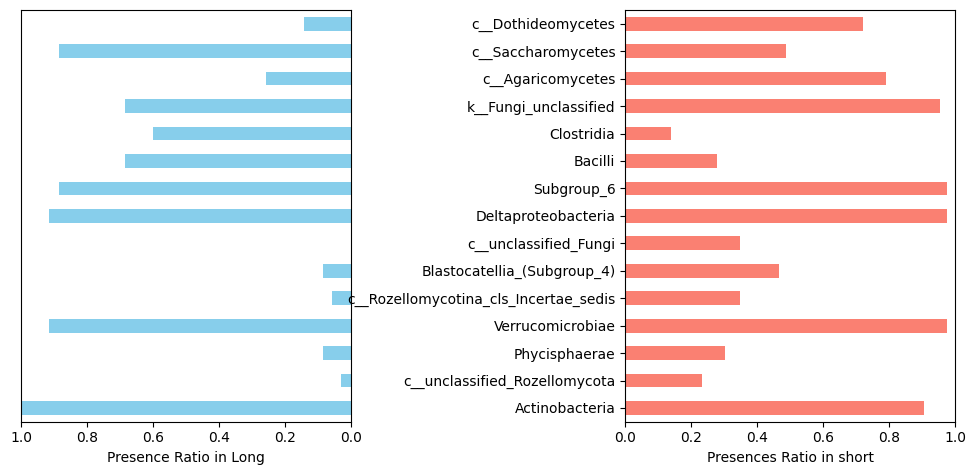

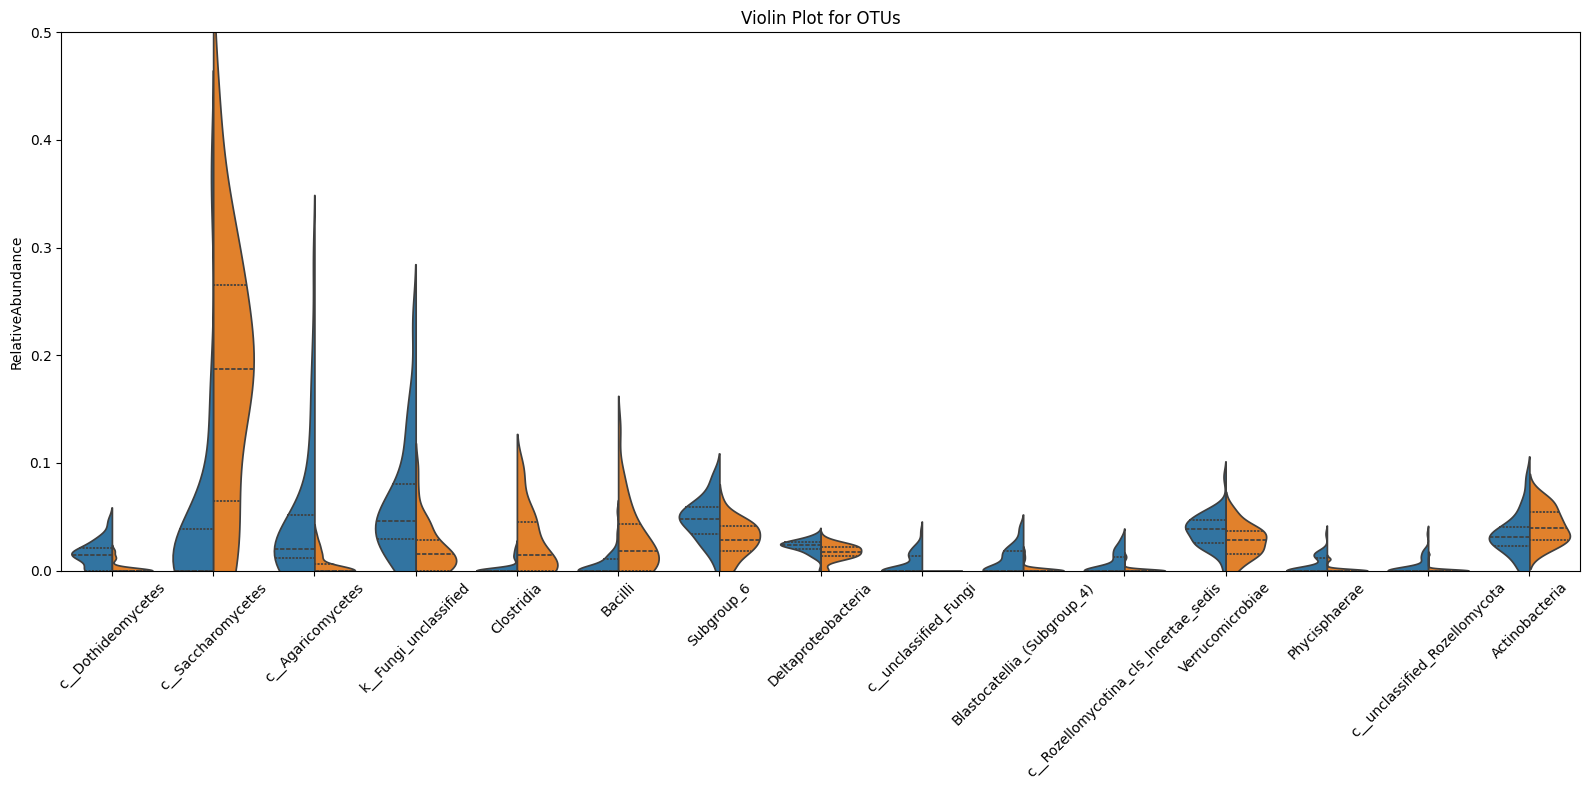

Index(['o__Saccharomycetales', 'k__Fungi_unclassified', 'Clostridiales',
       'Pedosphaerales', 'Subgroup_6_or', 'o__unclassified_Fungi',
       'Chitinophagales', 'o__Pleosporales', 'Bacillales',
       'Bacilli_unclassified', 'Corynebacteriales', 'Tepidisphaerales',
       'o__Agaricales', 'Pyrinomonadales', 'o__unclassified_Rozellomycota'],
      dtype='object')
(78, 15)
Validation passed: Dimensions are correct.
Long= 35, short = 43
                              OTU  presence_pos  presence_neg
0            o__Saccharomycetales      0.885714      0.488372
1           k__Fungi_unclassified      0.685714      0.953488
2                   Clostridiales      0.600000      0.139535
3                  Pedosphaerales      0.000000      0.418605
4                   Subgroup_6_or      0.885714      0.976744
5           o__unclassified_Fungi      0.000000      0.348837
6                 Chitinophagales      0.314286      0.744186
7                 o__Pleosporales      0.085714      0.441860

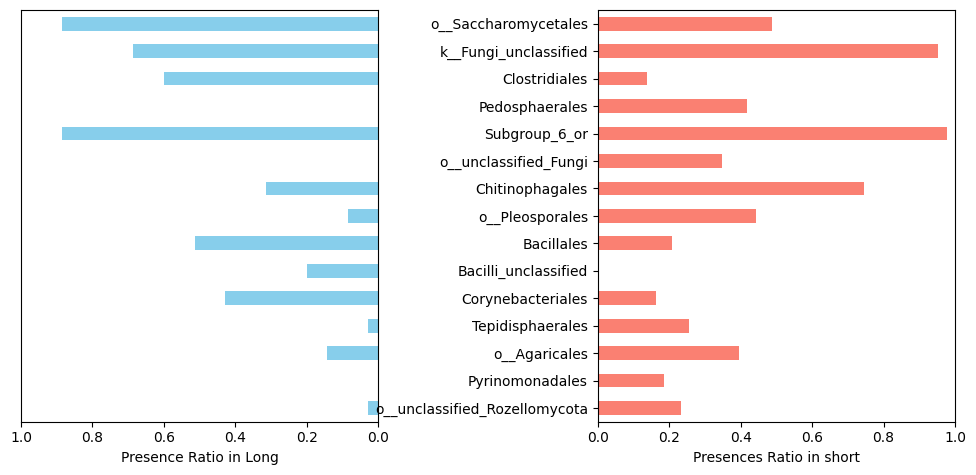

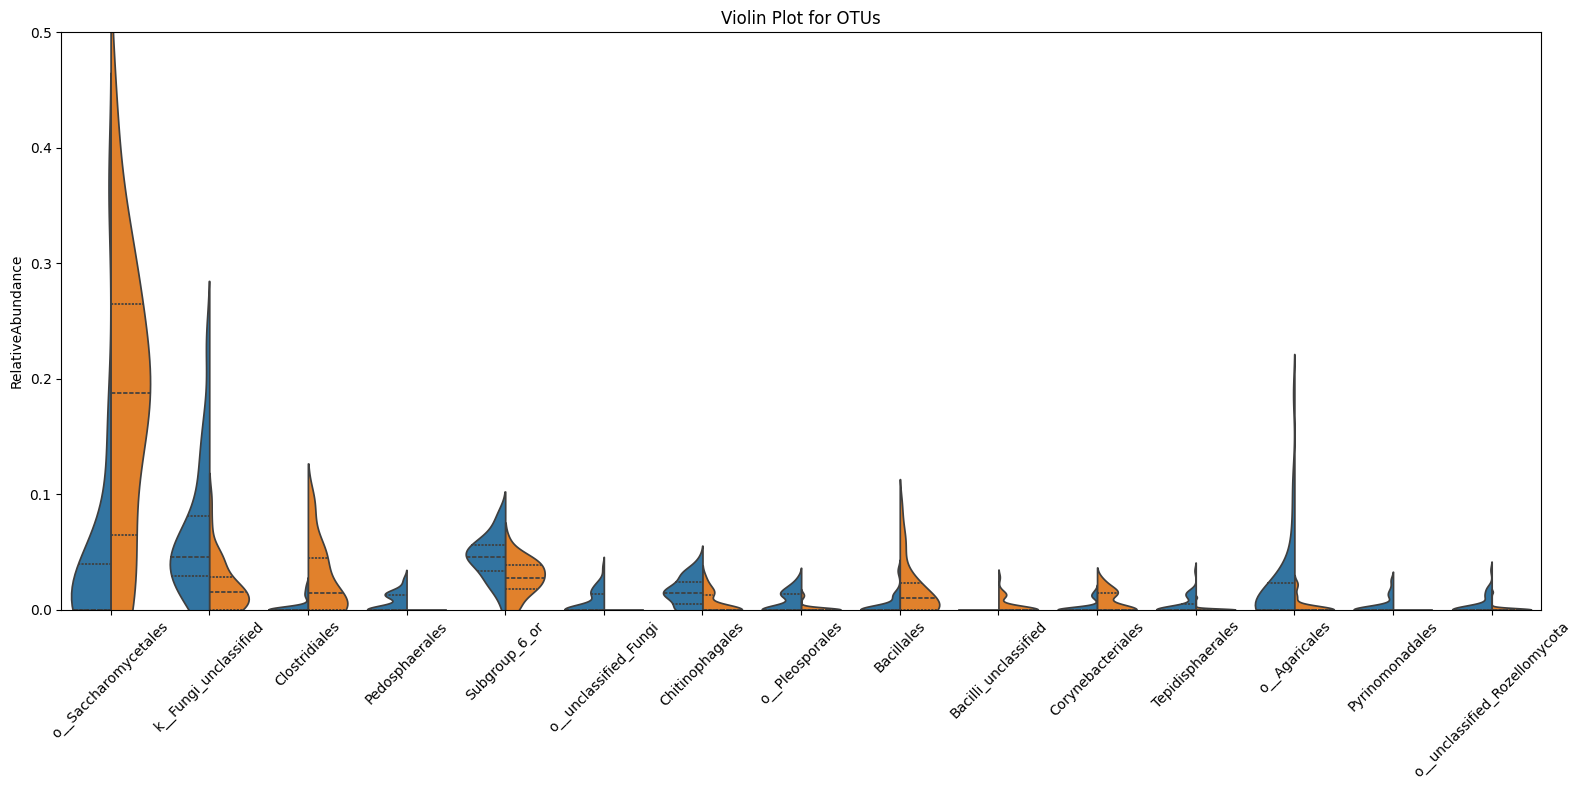

Index(['Firmicutes', 'p__Rozellomycota', 'k__Fungi_unclassified',
       'Acidobacteria', 'p__unclassified_Fungi', 'p__Chytridiomycota',
       'p__Ascomycota', 'Verrucomicrobia', 'p__Glomeromycota',
       'Gemmatimonadetes', 'Planctomycetes', 'Bacteroidetes',
       'p__Mortierellomycota'],
      dtype='object')
(78, 13)
Validation passed: Dimensions are correct.
Long= 35, short = 43
                      OTU  presence_pos  presence_neg
0              Firmicutes      0.942857      0.418605
1        p__Rozellomycota      0.171429      0.767442
2   k__Fungi_unclassified      0.685714      0.953488
3           Acidobacteria      0.971429      1.000000
4   p__unclassified_Fungi      0.000000      0.348837
5      p__Chytridiomycota      0.000000      0.325581
6           p__Ascomycota      1.000000      1.000000
7         Verrucomicrobia      0.914286      0.976744
8        p__Glomeromycota      0.000000      0.162791
9        Gemmatimonadetes      0.057143      0.232558
10         Planct

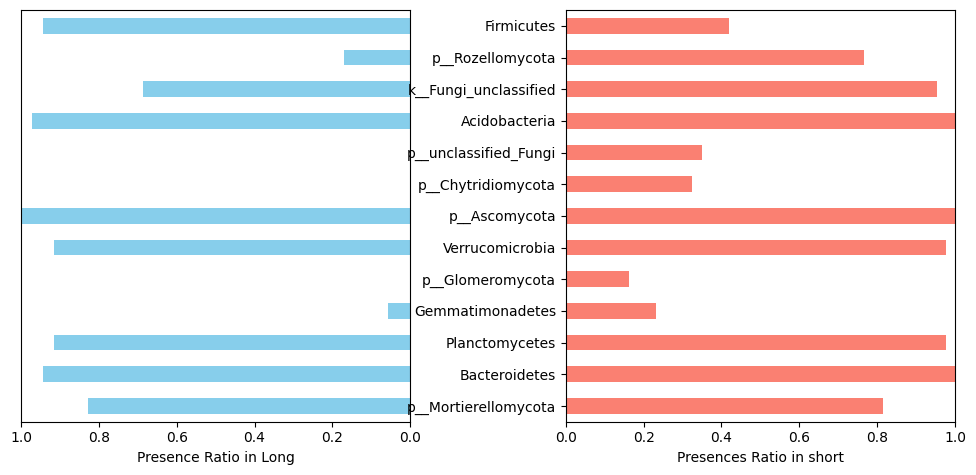

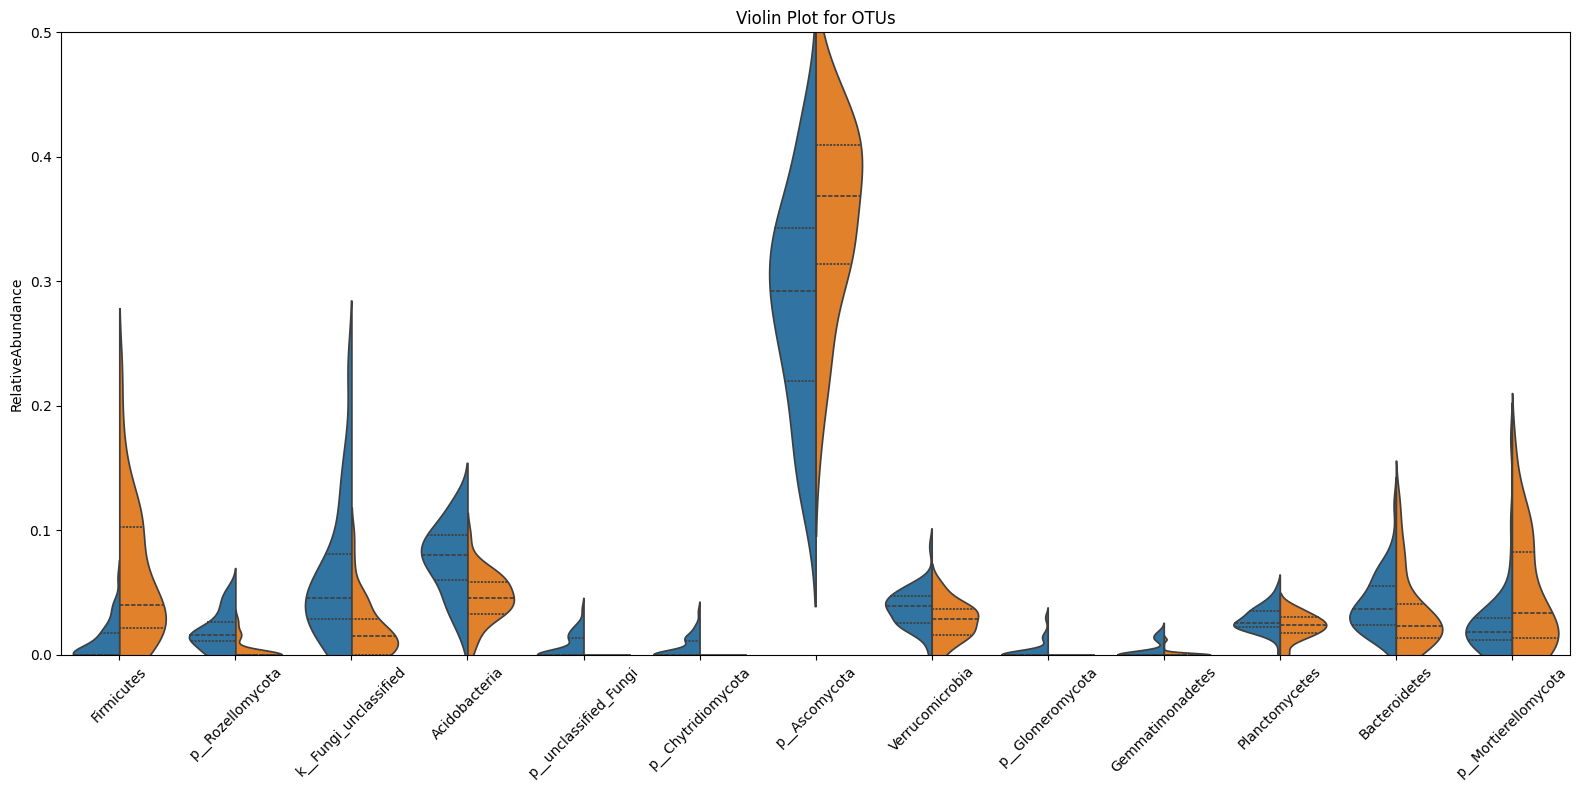

In [21]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

entries=15

for i, data_FS in enumerate(X_FS_4taxa):
    selectedASVs_15=selectedASVs_4taxa[i][:entries]
    print(selectedASVs_15)
    X_FS_15=data_FS[:,:entries]
    print(X_FS_15.shape)
    #df=pd.DataFrame(data=X_FS_15)
    FS.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs_15,posLabel="LONG",posText="Long",negText="short")
    FS.OTUviolin(X_FS_15,targetLabel,selectedASVs_15,y_max=0.5)

In [22]:
for i, data_FS in enumerate(X_lasso_ft_4taxa):
    selectedASVs_15=col_names_4taxa[i][xind_lasso_ft_4taxa[i]]
    print(f"Fine tuned Lasso selected {selectedASVs_15}")
    X_FS_15=data_4taxa[i][:,xind_lasso_ft_4taxa[i]]
    #df=pd.DataFrame(data=X_FS_15)
    FS.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs_15,posLabel="LONG",posText="Long",negText="short")
    FS.OTUviolin(X_FS_15,targetLabel,selectedASVs_15,y_max=0.5) 
    

NameError: name 'X_lasso_ft_4taxa' is not defined

In [ ]:
for i, data_FS in enumerate(X_FS_lassoft_4taxa):
    selectedASVs_15=col_names_4taxa[i][selectedOTU_index_FS_lassoft_4taxa[i]]
    print(f"FS_Fine tuned Lasso selected {selectedASVs_15}")
    X_FS_15=data_4taxa[i][:,selectedOTU_index_FS_lassoft_4taxa[i]]
    #df=pd.DataFrame(data=X_FS_15)
    FS.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs_15,posLabel="LONG",posText="Long",negText="short")
  

In [ ]:
X_FS_lassoft_4taxa